# Redes neuronales recurrentes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
tf.keras.backend.clear_session()

In [3]:
if tf.test.gpu_device_name():

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


Esta celda monta el Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Datos de transporte

Obtengamos los datos de la cantidad de pasajeros en Chicago

In [5]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [6]:
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

df.head(6)


,service_date,day_type,bus,rail_boardings,total_rides
0,2001-01-01,U,297192,126455,423647
1,2001-01-02,W,780827,501952,1282779
2,2001-01-03,W,824923,536432,1361355
3,2001-01-04,W,870021,550011,1420032
4,2001-01-05,W,890426,557917,1448343
5,2001-01-06,A,577401,255356,832757


Para simplificar las cosas, vamos a cambiar nombres y a hacer algo de preparativos.

In [7]:
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")

df.head(6)

,day_type,bus,rail,total
date,,,,
2001-01-01,U,297192,126455,423647
2001-01-02,W,780827,501952,1282779
2001-01-03,W,824923,536432,1361355
2001-01-04,W,870021,550011,1420032
2001-01-05,W,890426,557917,1448343
2001-01-06,A,577401,255356,832757


In [8]:
df = df.drop("total", axis=1)  # tiramos el total que no es más que la suma de bus + rail
df = df.drop_duplicates()  # sacamos meses duplicados (2011-10 y 2014-07)

df.head(6)

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
2001-01-06,A,577401,255356


Ahora veamos los primeros meses de datos

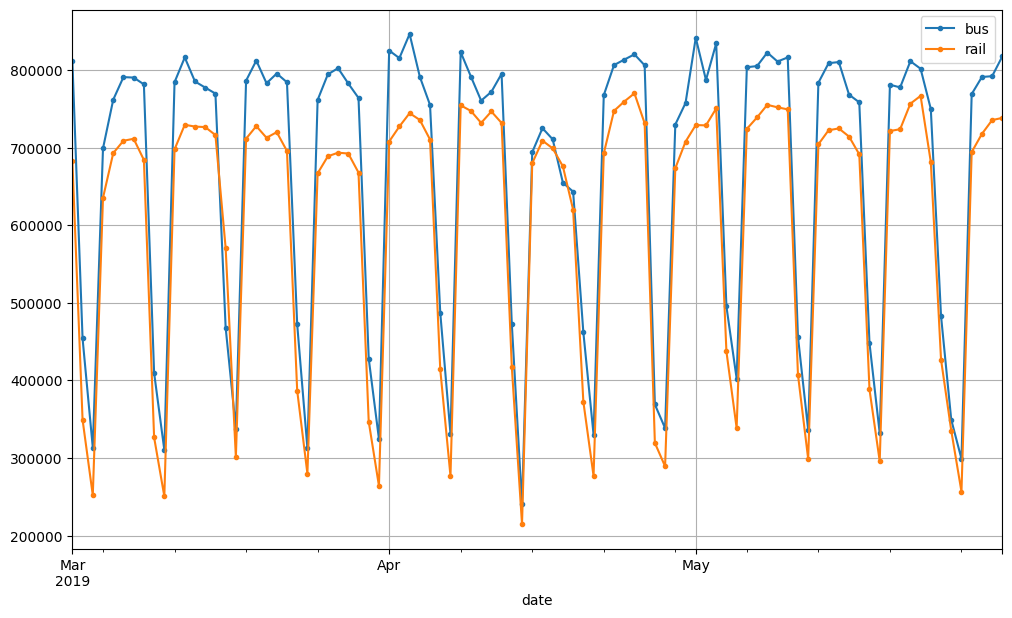

In [81]:
import matplotlib.pyplot as plt

# df.plot(grid=True, marker="", figsize=(12, 7))
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(12, 7))
plt.show()

Antes de seguir mirando la data, vamos a separarla en tres conjuntos, paara entrenamiento, validación y testeo.

In [66]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":"2020-02"] / 1e6

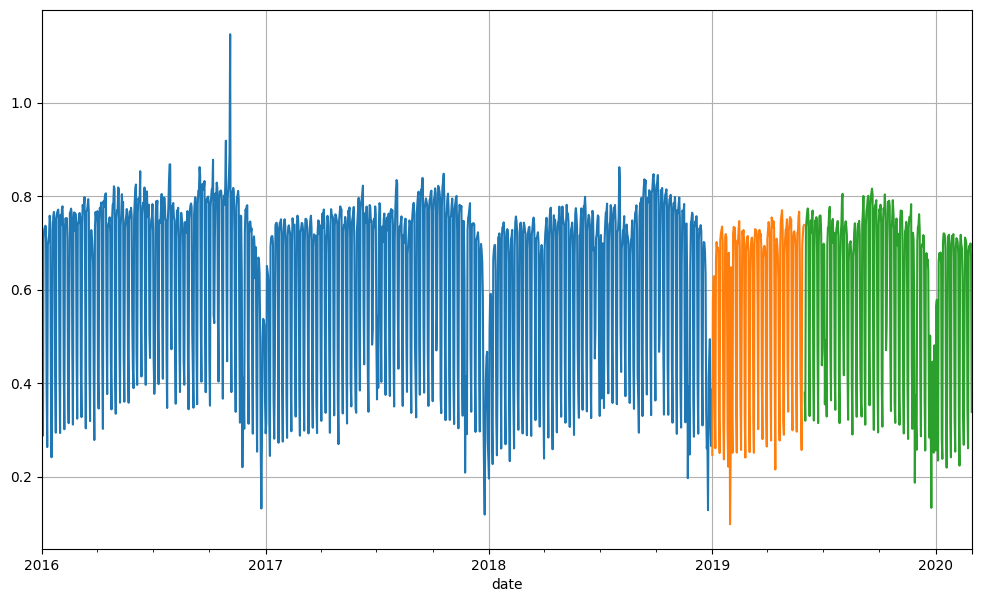

In [11]:
import matplotlib.pyplot as plt

rail_train.plot(grid=True, marker="", figsize=(12, 7), label='Entrenamiento')
rail_valid.plot(grid=True, marker="", figsize=(12, 7), label='Validación')
rail_test.plot(grid=True, marker="", figsize=(12, 7), label='Testeo')
# df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(12, 7))
plt.show()

<Axes: xlabel='date'>

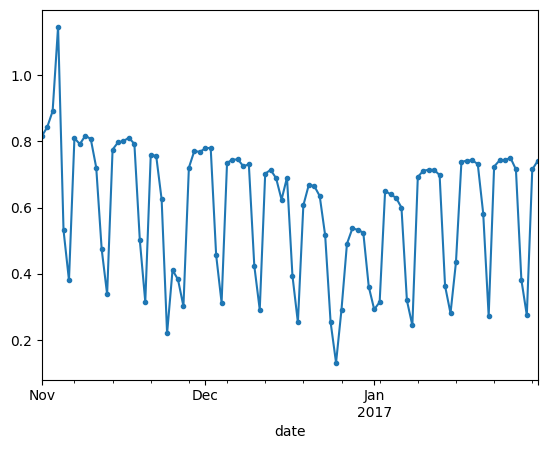

In [12]:
rail_train["2016-11":"2017-01"].plot(marker='.')

Vamos a poner los datos en un formato que le viene bien a TensorFlow.

In [13]:
len(rail_train.to_numpy())

1096

In [74]:
seq_length = 56
tf.random.set_seed(42)  # extra code – asegura reproducibilidad
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=False,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

In [75]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [76]:
for i, batch in enumerate(train_ds):
    if i < 4:
        print('Batch {}'.format(i+1))

        print('Data', batch[0][0])
        print('Target', batch[1][0])
        print('=====')
        print('Data', batch[0][1])
        print('Target', batch[1][1])


Batch 1
Data tf.Tensor(
[0.319835 0.365509 0.287661 0.703185 0.727716 0.733167 0.736809 0.732495
 0.391597 0.263073 0.694734 0.705694 0.716663 0.758116 0.742622 0.404212
 0.24116  0.405686 0.727458 0.758524 0.766262 0.745168 0.416999 0.293804
 0.751104 0.764023 0.768241 0.771161 0.75109  0.427874 0.293056 0.759849
 0.739247 0.772821 0.778227 0.731495 0.423602 0.301141 0.733387 0.752849
 0.742445 0.752703 0.706242 0.392095 0.314191 0.54839  0.764147 0.76694
 0.773317 0.761996 0.464149 0.31119  0.745072 0.765309 0.725712 0.762858], shape=(56,), dtype=float64)
Target tf.Tensor(0.749991, shape=(), dtype=float64)
=====
Data tf.Tensor(
[0.365509 0.287661 0.703185 0.727716 0.733167 0.736809 0.732495 0.391597
 0.263073 0.694734 0.705694 0.716663 0.758116 0.742622 0.404212 0.24116
 0.405686 0.727458 0.758524 0.766262 0.745168 0.416999 0.293804 0.751104
 0.764023 0.768241 0.771161 0.75109  0.427874 0.293056 0.759849 0.739247
 0.772821 0.778227 0.731495 0.423602 0.301141 0.733387 0.752849 0.74244

## Modelo de base

Como modelo de base, vamos a usar una red densa de una única neurona (es decir, una regresión lineal!).
Esa regresión va a intentar tomar los datos de la serie temporal y encontrar los pesos necesarios para predecir el próximo paso.

In [17]:
tf.random.set_seed(42)
model_lr = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model_lr.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])


In [18]:
model_lr.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 57        
                                                                 
Total params: 57 (228.00 Byte)
Trainable params: 57 (228.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
ajuste_lr = model_lr.fit(train_ds, validation_data=valid_ds, epochs=500,
                        callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 5s 11ms/step - loss: 0.0934 - mae: 0.3522 - val_loss: 0.0088 - val_mae: 0.1010
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0102 - mae: 0.1067 - val_loss: 0.0119 - val_mae: 0.1265
Epoch 3/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0103 - mae: 0.1109 - val_loss: 0.0088 - val_mae: 0.1045
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0093 - mae: 0.1047 - val_loss: 0.0075 - val_mae: 0.0940
Epoch 5/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0083 - mae: 0.0977 - val_loss: 0.0068 - val_mae: 0.0880
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0075 - mae: 0.0923 - val_loss: 0.0063 - val_mae: 0.0831
Epoch 7/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0069 - mae: 0.0879 - val_loss: 0.0058 - val_mae: 0.0791
Epoch 8/500
33/33 [==============================] - 0s 13ms/step - loss: 0.006

$$
MAE = \frac{1}{N} \sum_{i=1}^N | y_i - t_i |
$$

In [20]:
valid_loss, valid_mae = model_lr.evaluate(valid_ds)

print('MAE (regresión lineal) --> {:.2f} pasajeros'.format(valid_mae * 1e6))

3/3 [==============================] - 0s 6ms/step - loss: 0.0030 - mae: 0.0578
MAE (regresión lineal) --> 57791.18 pasajeros


## Una red recurrente simple

En comparación, creemos una red recurrente con una única neurona.

Fíjense que en este caso, no tenemos que especificar la longitud de la secuencia. Esa es una de las primeras grandes ventajas de esta arquitectura. Podríamos usar la misma red para secuencias muy diferentes. En cambio, sí tenemos que darle la dimensionalidad de la secuencia. En este caso, es 1, porque tenemos una serie univariada.

In [21]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model_1unidad = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, activation='tanh', input_shape=[None, 1])
])

Definimos una función útil para hacer el entrenamiento con early stopping, y para evaluar el modelo, que vamos a usar bastante

In [22]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, fit=False, epochs=500):

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    if fit:
        history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                            callbacks=[early_stopping_cb])
        valid_loss, valid_mae = model.evaluate(valid_set)
        return valid_mae * 1e6
    else:
        return

In [77]:
fit_and_evaluate(model_1unidad, train_ds, valid_ds, 0.05, fit=True)

Epoch 1/500
33/33 [==============================] - 8s 101ms/step - loss: 0.0104 - mae: 0.1127 - val_loss: 0.0102 - val_mae: 0.1033
Epoch 2/500
33/33 [==============================] - 2s 46ms/step - loss: 0.0104 - mae: 0.1135 - val_loss: 0.0102 - val_mae: 0.1031
Epoch 3/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0104 - mae: 0.1133 - val_loss: 0.0102 - val_mae: 0.1031
Epoch 4/500
33/33 [==============================] - 1s 44ms/step - loss: 0.0104 - mae: 0.1133 - val_loss: 0.0102 - val_mae: 0.1031
Epoch 5/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0104 - mae: 0.1133 - val_loss: 0.0102 - val_mae: 0.1031
Epoch 6/500
33/33 [==============================] - 3s 82ms/step - loss: 0.0104 - mae: 0.1133 - val_loss: 0.0102 - val_mae: 0.1031
Epoch 7/500
33/33 [==============================] - 2s 62ms/step - loss: 0.0104 - mae: 0.1132 - val_loss: 0.0102 - val_mae: 0.1031
Epoch 8/500
33/33 [==============================] - 1s 43ms/step - loss: 0

KeyboardInterrupt: ignored

In [78]:
# model_1unidad = keras.models.load_model('..//content/drive/MyDrive/modelosAP/simpleRNN_1unit.h5')
model_1unidad.load_weights('/content/drive/MyDrive/modelosAP/simpleRNN_1unit_weights.h5')

In [25]:
valid_mae = model_1unidad.evaluate(valid_ds)[1]

print('MAE (RNN con una unidad) --> {:.2f} pasajeros'.format(valid_mae * 1e6))

3/3 [==============================] - 1s 22ms/step - loss: 0.0103 - mae: 0.1029
MAE (RNN con una unidad) --> 102865.92 pasajeros


Como vemos, el resultado da mucho peor que antes.
O sea que la red recurrente de una neurona funciona peor que una regresión lineal simple.

¿Qué está pasando? ¿Alguna idea? Pensemos en el número de parámetros

In [26]:
model_1unidad.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Una RNN con más neuronas

In [27]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [28]:
univar_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Ahora tenemos muchos más parámetros.

Hay un parámetro para cada neurona y cada entrada de la secuencia (32), más un parámetro para cada neurona y cada salida del paso anterrior de cada neurona (32 x 32), más un término de sesgo para cada neurona (32).

32 + 32 x 32 + 32 = 1088

In [29]:
for W in univar_model.layers[0].get_weights():
    print(W.shape)

(1, 32)
(32, 32)
(32,)


Compilamos el modelo para poder usar los pesos pre-entrenados para predecir.

In [30]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05, fit=True)

Epoch 1/500
33/33 [==============================] - 3s 51ms/step - loss: 0.0455 - mae: 0.2384 - val_loss: 0.0206 - val_mae: 0.1736
Epoch 2/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0083 - mae: 0.0968 - val_loss: 0.0056 - val_mae: 0.0859
Epoch 3/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0064 - mae: 0.0881 - val_loss: 0.0053 - val_mae: 0.0883
Epoch 4/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0066 - mae: 0.0931 - val_loss: 0.0052 - val_mae: 0.0883
Epoch 5/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0084 - mae: 0.1076 - val_loss: 0.0024 - val_mae: 0.0445
Epoch 6/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0079 - mae: 0.1007 - val_loss: 0.0041 - val_mae: 0.0699
Epoch 7/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0049 - mae: 0.0730 - val_loss: 0.0035 - val_mae: 0.0631
Epoch 8/500
33/33 [==============================] - 2s 60ms/step - loss: 0.

34146.81181311607

In [31]:
univar_model.load_weights('/content/drive/MyDrive/modelosAP/simpleRNN_32units_weights.h5')

In [32]:
valid_mae = univar_model.evaluate(valid_ds)[1]

print('MAE (RNN con 32 unidades) --> {:.2f} pasajeros'.format(valid_mae * 1e6))

3/3 [==============================] - 0s 14ms/step - loss: 0.0018 - mae: 0.0304
MAE (RNN con 32 unidades) --> 30423.45 pasajeros


Ahora sí, alcanzamos una performance similar a la del modelo de regresión lineal.

## Redes recurrentes profundas.

Pero todavía no desencadenamos todo el poder de las redes neuronales recurrentes.

Así como para otras arquitecturas se apilaban capas, acá también podemos hacerlo.

In [33]:
tf.random.set_seed(42)  # fijamos la semilla para asegurar la reproductibilidad
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [34]:
deep_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          1088      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5281 (20.63 KB)
Trainable params: 5281 (20.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# compila, ajusta y evalúa el modelo
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01, fit=False)

Cargamos los pesos pre-entrenados (gracias, Colab!)

In [36]:
deep_model.load_weights('/content/drive/MyDrive/modelosAP/deepRNN_weights.h5')

In [37]:
valid_mae = deep_model.evaluate(valid_ds)[1]

print('MAE (RNN profunda) --> {:.2f} pasajeros'.format(valid_mae * 1e6))

3/3 [==============================] - 1s 31ms/step - loss: 0.0019 - mae: 0.0326
MAE (RNN profunda) --> 32612.36 pasajeros


Vemos que el resultado no es mucho mejor.
Esto puede deberse a un problema con el entrenamiento, y muestra lo complejo de entrenar estas redes.

In [79]:
mae = {}
for n, m in zip(['Linear', 'Simple (1 unidad)', 'Simple (32 unidades)', 'Deep'],[model_lr, model_1unidad, univar_model, deep_model]):
    mae[n] = [m.evaluate(valid_ds)[1]*1e6, m.count_params()]

3/3 [==============================] - 1s 116ms/step - loss: 0.0019 - mae: 0.0326


In [80]:
mae

{'Linear': [57791.177183389664, 57],
 'Simple (1 unidad)': [102865.91947078705, 3],
 'Simple (32 unidades)': [30423.453077673912, 1121],
 'Deep': [32612.357288599014, 5281]}

A continuación, vamos a intentar hacer lo mismo con un conjunto de secuencias multivariadas como input

## Series temporales multivaridas

Ahora el objetivo es predecir la cantidad de pasajeros futuros en el tren, usando tanto los pasajeros de tren como de bus.

In [40]:
df.head(10)

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
2001-01-06,A,577401,255356
2001-01-07,U,375831,169825
2001-01-08,W,985221,590706
2001-01-09,W,978377,599905


In [41]:
df_mulvar = df[["bus", "rail"]] / 1e6

# Además, le damos como info el tipo del día de mañana
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type

# Al que codificamos con un one-hot
df_mulvar = pd.get_dummies(df_mulvar)

In [82]:
df_mulvar.head(20)

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0
2001-01-06,0.577401,0.255356,0,1,0
2001-01-07,0.375831,0.169825,0,0,1
2001-01-08,0.985221,0.590706,0,0,1
2001-01-09,0.978377,0.599905,0,0,1


In [43]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":"2020-03"]

In [83]:
tf.random.set_seed(42) # fijamos la semilla para asegurar la reproductibilidad

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # usamos las cinco columnas como input
    targets=mulvar_train["rail"][seq_length:],  # predecimos solo la serie de los trenes.
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [84]:
train_mulvar_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [45]:
tf.random.set_seed(42)  # fijamos la semilla para asegurar la reproductibilidad
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [46]:
mulvar_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 32)                1216      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
5*32 + 32 + 32*32

1216

In [48]:
for a in mulvar_model.layers[0].get_weights():
    print(a.shape)

(5, 32)
(32, 32)
(32,)


In [49]:
# compila, ajusta y evalúa el modelo
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05, fit=False)

In [50]:
mulvar_model.load_weights('/content/drive/MyDrive/modelosAP/mulvarRNN_1output_weights.h5')

In [51]:
valid_mae = mulvar_model.evaluate(valid_mulvar_ds)[1]

print('MAE (RNN profunda) --> {:.2f} pasajeros'.format(valid_mae * 1e6))

3/3 [==============================] - 1s 21ms/step - loss: 6.2217e-04 - mae: 0.0235
MAE (RNN profunda) --> 23496.90 pasajeros


Vemos que incorporar toda la información sobre los buses y el día de la semana ayuda a las predicciones.

## Predicción de múltiples variables *

Ahora intentamos hacer la predicción de dos series a la vez.

In [85]:
tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets por día
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [86]:
train_multask_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

In [53]:
tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
], name='Multitask')

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02, fit=False)

In [54]:
multask_model.summary()

Model: "Multitask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 32)                1216      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1282 (5.01 KB)
Trainable params: 1282 (5.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
multask_model.load_weights('/content/drive/MyDrive/modelosAP/mulvarRNN_2outputs_weights.h5')

La evaluación de las predicciones es un poco más difícil que antes.

Comparamos con una predicción ingenua

In [56]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [57]:
Y_preds_valid = multask_model.predict(valid_multask_ds)

for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 10ms/step
bus 26369
rail 25330


Vemos que las predicciones son muy buenas para ambas variables.

# Celdas más complejas

## LSTMs

In [58]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [59]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4897 (19.13 KB)
Trainable params: 4897 (19.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Vamos a entrenar por solo 5 épocas para ver como funciona (lo pueden aumentar si quieren)

In [60]:
valid_mae = fit_and_evaluate(lstm_model, train_mulvar_ds, valid_mulvar_ds,
                             learning_rate=0.1, epochs=5, fit=True)

Epoch 1/5
33/33 [==============================] - 3s 21ms/step - loss: 0.0337 - mae: 0.2018 - val_loss: 0.0047 - val_mae: 0.0810
Epoch 2/5
33/33 [==============================] - 0s 10ms/step - loss: 0.0050 - mae: 0.0789 - val_loss: 0.0026 - val_mae: 0.0597
Epoch 3/5
33/33 [==============================] - 0s 10ms/step - loss: 0.0031 - mae: 0.0582 - val_loss: 0.0018 - val_mae: 0.0491
Epoch 4/5
33/33 [==============================] - 0s 10ms/step - loss: 0.0028 - mae: 0.0552 - val_loss: 0.0036 - val_mae: 0.0742
Epoch 5/5
3/3 [==============================] - 0s 10ms/step - loss: 0.0017 - mae: 0.0473


In [61]:
print('MAE (LSTM) --> {:.2f} pasajeros'.format(valid_mae))

MAE (LSTM) --> 47325.90 pasajeros


## GRUs

In [62]:
tf.random.set_seed(42)  # fijamos la semilla para asegurar la reproductibilidad
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=False, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

Vamos a entrenar por solo 5 épocas para ver como funciona (lo pueden aumentar si quieren)

In [63]:
valid_mae = fit_and_evaluate(gru_model, train_mulvar_ds, valid_mulvar_ds,
                             learning_rate=0.1, epochs=5, fit=True)

Epoch 1/5
33/33 [==============================] - 2s 20ms/step - loss: 0.0291 - mae: 0.1807 - val_loss: 0.0026 - val_mae: 0.0626
Epoch 2/5
33/33 [==============================] - 0s 10ms/step - loss: 0.0031 - mae: 0.0578 - val_loss: 0.0026 - val_mae: 0.0633
Epoch 3/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0027 - mae: 0.0529 - val_loss: 0.0013 - val_mae: 0.0399
Epoch 4/5
33/33 [==============================] - 1s 14ms/step - loss: 0.0025 - mae: 0.0507 - val_loss: 0.0019 - val_mae: 0.0529
Epoch 5/5
3/3 [==============================] - 0s 13ms/step - loss: 0.0015 - mae: 0.0453


In [64]:
print('MAE (GRU) --> {:.2f} pasajeros'.format(valid_mae))

MAE (GRU) --> 45294.17 pasajeros
